# Redes Generativas Antagonicas - GAN

### Requisitos: pip install tensorflow numpy matplotlib

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2025-04-30 08:58:19.497691: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 08:58:19.565011: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 08:58:20.364286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 08:58:20.364323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 08:58:20.393809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# cargar el dataset MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0  # normalizar imágenes entre 0 y 1
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')  # cambiar la forma a (num_samples, 28, 28, 1)

In [3]:
# tamaño del espacio latente (ruido de entrada para el generador)
latent_dim = 100

In [4]:
# crear el generador
def build_generator():
    model = Sequential(
        [
            Dense(256, input_dim=latent_dim),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(512),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(1024),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(28 * 28 * 1, activation="tanh"),
            Reshape((28, 28, 1)),
        ]
    )
    return model

In [5]:
# crear el discriminador
def build_discriminador():
    model = Sequential(
        [
            Flatten(input_shape=(28, 28, 1)),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dense(1, activation="sigmoid"),  # clasificacion entre real 1 y falso 0
        ]
    )
    return model

In [6]:
# compilar el model
discriminador = build_discriminador()
discriminador.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

2025-04-30 08:58:29.406628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-30 08:58:29.409954: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# compilar el generador (dentro de GAN)
generador = build_generator()

In [8]:
# congelar el discriminador durante el entrenamiento del generador
discriminador.trainable = False

# crear la GAN combinando el generador y el discriminador
gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminador(generador(gan_input))
gan = tf.keras.Model(gan_input, gan_output)

In [9]:
# compilar la GAN
gan.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
)

In [10]:
def generate_and_save_images(
    epoch, generator, ejemplos=16, dim=(4, 4), figsize=(10, 10)
):
    noise = np.random.normal(0, 1, size=(ejemplos, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(ejemplos, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        # crear una subgráfica para cada imagen generada
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation="nearest", cmap="gray_r")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"gan_generated_epoch_{epoch}.png")
    plt.show()


In [11]:
def train_gan(epochs=10000, batch_size=128):
    batch_count = x_train.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            generated_images = generador.predict(noise)
            real_images = x_train[
                np.random.randint(0, x_train.shape[0], size=batch_size)
            ]

            X = np.concatenate([real_images, generated_images])
            Y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

            d_loss = discriminador.train_on_batch(X, Y)
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            d_loss_val = d_loss[0] if isinstance(d_loss, (list, tuple)) else d_loss
            g_loss_val = g_loss[0] if isinstance(g_loss, (list, tuple)) else g_loss

            print(
                f"Epoch {epoch} | Discriminator Loss: {d_loss_val} | Generator Loss: {g_loss_val}"
            )

            generate_and_save_images(epoch, generador)


4/4 [==============================] - 0s 1ms/step
Epoch 0 | Discriminator Loss: 0.5040191411972046 | Generator Loss: 1.4383059740066528
1/1 [==============================] - 0s 46ms/step


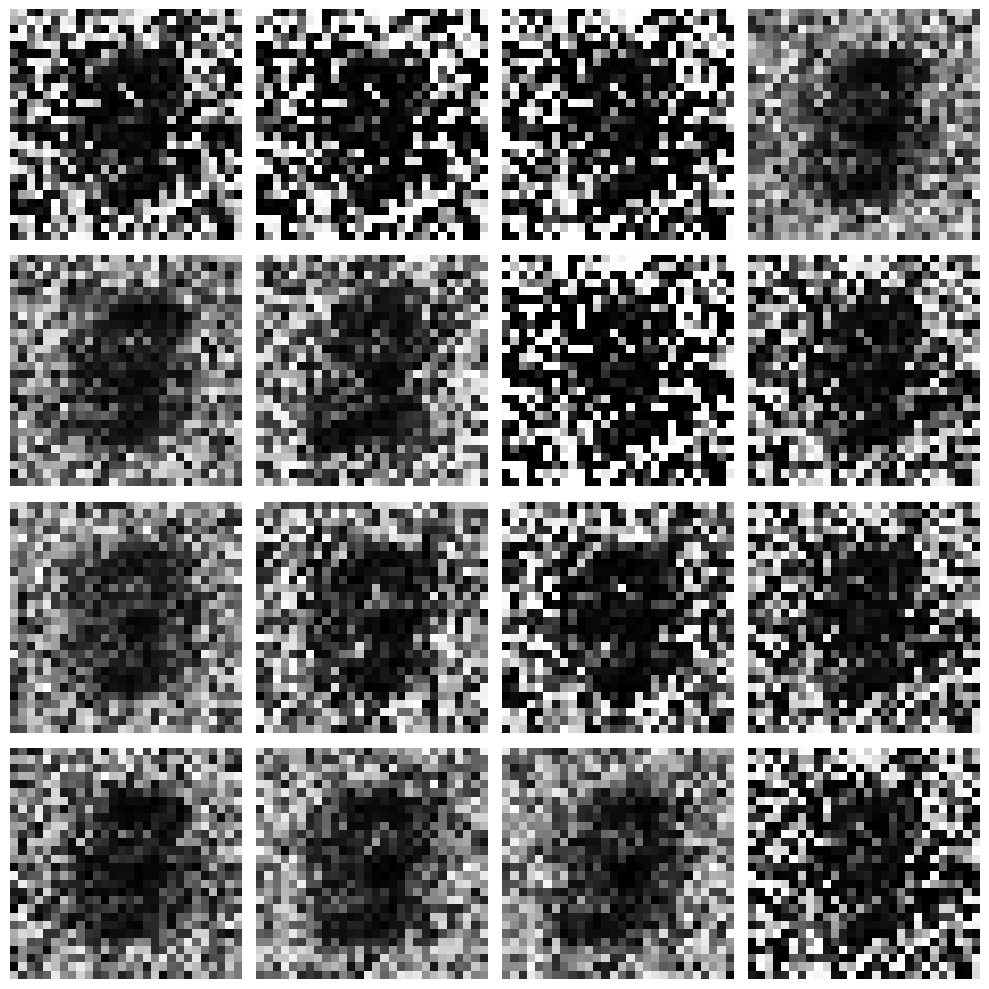

4/4 [==============================] - 0s 1ms/step


KeyboardInterrupt: 

In [12]:
train_gan(epochs=10000, batch_size=128)